In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, classification_report
import plotly.express as px
from scipy import stats as ss

In [4]:
Telco_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
Telco_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
Telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
Telco_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

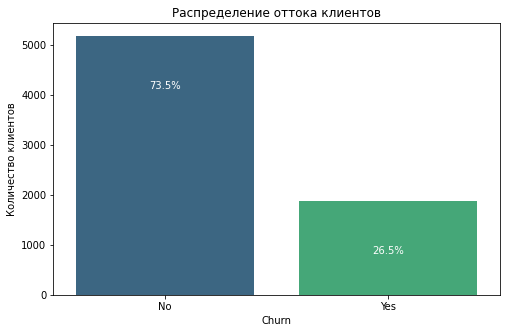


Процент оттока клиентов:
No     73.5
Yes    26.5
Name: Churn, dtype: float64


In [8]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Churn', data=Telco_data, palette='viridis')

total = len(Telco_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() - 0.15 * total 
    ax.annotate(percentage, (x, y), ha='center', color='white') 
plt.title('Распределение оттока клиентов')
plt.ylabel('Количество клиентов')
plt.show()

churn_rate = Telco_data['Churn'].value_counts(normalize=True).mul(100).round(1)
print(f"\nПроцент оттока клиентов:\n{churn_rate}")

In [9]:
churn_rate = Telco_data['Churn'].value_counts(normalize=True) * 100
print(f"\nПроцент оттока клиентов:\n{churn_rate}")


Процент оттока клиентов:
No     73.463013
Yes    26.536987
Name: Churn, dtype: float64


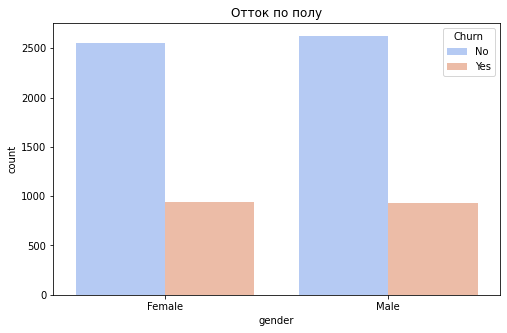

In [10]:
#Отток по полу
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='Churn', data=Telco_data, palette='coolwarm')
plt.title('Отток по полу')
plt.show()

In [11]:
#Статистическая проверка (хи-квадрат)
contingency_table = pd.crosstab(Telco_data['gender'], Telco_data['Churn'])
chi2, p, _, _ = ss.chi2_contingency(contingency_table)
print(f"\np-value для теста хи-квадрат (пол vs отток): {p:.4f}")


p-value для теста хи-квадрат (пол vs отток): 0.4866


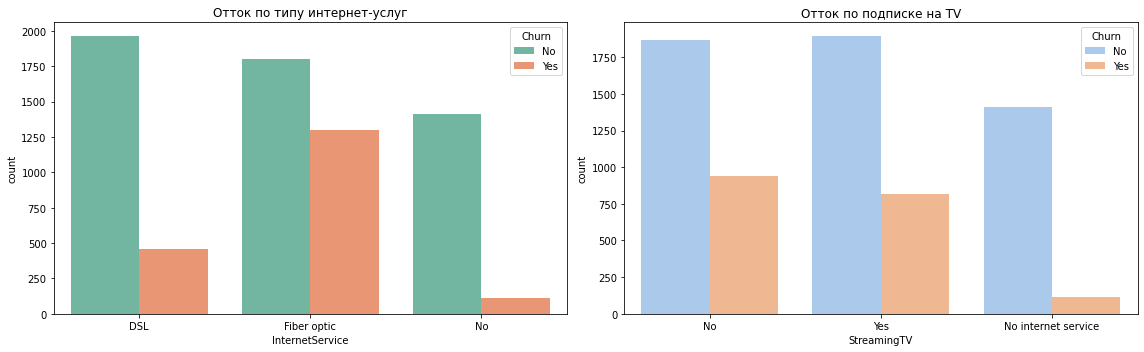

In [12]:
# Влияние интернета/ТВ на отток
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='InternetService', hue='Churn', data=Telco_data, ax=axes[0], palette='Set2')
axes[0].set_title('Отток по типу интернет-услуг')
sns.countplot(x='StreamingTV', hue='Churn', data=Telco_data, ax=axes[1], palette='pastel')
axes[1].set_title('Отток по подписке на TV')
plt.tight_layout()
plt.show()

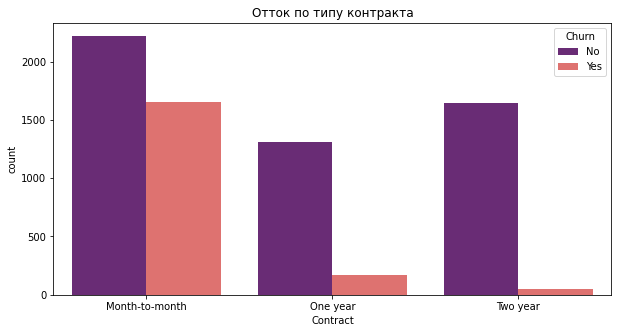

In [13]:
# Влияние типа контракта
plt.figure(figsize=(10, 5))
sns.countplot(x='Contract', hue='Churn', data=Telco_data, palette='magma', order=['Month-to-month', 'One year', 'Two year'])
plt.title('Отток по типу контракта')
plt.show()

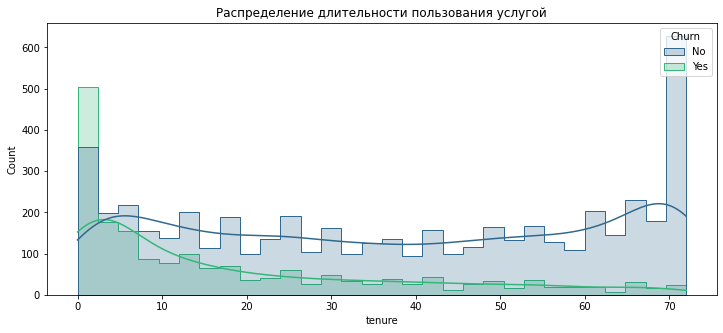

In [14]:
# Распределение tenure (длительность пользования)
plt.figure(figsize=(12, 5))
sns.histplot(data=Telco_data, x='tenure', hue='Churn', bins=30, kde=True, element='step', palette='viridis')
plt.title('Распределение длительности пользования услугой')
plt.show()

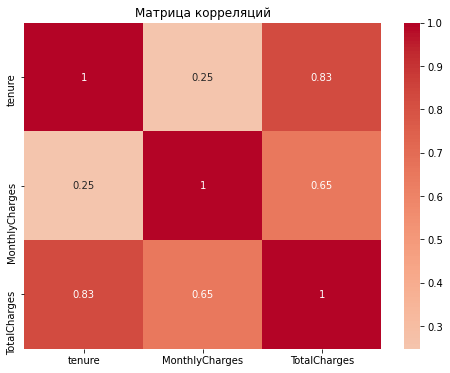

In [15]:
# Корреляция числовых признаков
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
Telco_data[numeric_cols] = Telco_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(8, 6))
sns.heatmap(Telco_data[numeric_cols + ['Churn']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

In [16]:
#RFM-анализ + Кластеризация
def calculate_rfm(Telco_data):
    rfm = Telco_data.groupby('customerID').agg({
        'tenure': lambda x: (Telco_data['tenure'].max() - x.max()),  # Recency
        'MonthlyCharges': 'count',  # Frequency
        'TotalCharges': 'sum'       # Monetary
    })
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    return rfm

rfm_data = calculate_rfm(Telco_data)

In [17]:
rfm_data.head()

,Recency,Frequency,Monetary
customerID,,,
0002-ORFBO,63,1,593.30
0003-MKNFE,63,1,542.40
0004-TLHLJ,68,1,280.85
0011-IGKFF,59,1,1237.85
0013-EXCHZ,69,1,267.40


In [18]:
# Нормализация данных
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

In [19]:
# Кластеризация K-means
kmeans = KMeans(n_clusters=4, random_state=42)
Telco_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [20]:
# Преобразование категориальных переменных
X = pd.get_dummies(Telco_data.drop(['customerID', 'Churn', 'TotalCharges'], axis=1))
y = Telco_data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [21]:
# Обучение модели
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X, y)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [22]:
# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]
}).sort_values('Importance', ascending=False)

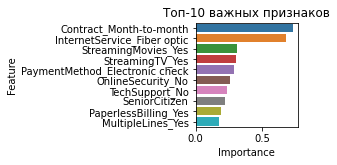

In [23]:
plt.subplot(2, 2, 4)
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Топ-10 важных признаков')

plt.tight_layout()
plt.show()

In [24]:
report = f"""
Аналитический отчет по оттоку клиентов:
1. Общий уровень оттока: {Telco_data['Churn'].value_counts(normalize=True)['Yes']:.2%}
2. Топ-3 фактора оттока:
   - {feature_importance.iloc[0]['Feature']} (важность: {feature_importance.iloc[0]['Importance']:.2f})
   - {feature_importance.iloc[1]['Feature']} (важность: {feature_importance.iloc[1]['Importance']:.2f})
   - {feature_importance.iloc[2]['Feature']} (важность: {feature_importance.iloc[2]['Importance']:.2f})
3. Рекомендации:
   - Фокус на кластере {Telco_data[Telco_data['Churn']=='Yes']['Cluster'].mode()[0]} с максимальным оттоком
   - Превентивные меры для клиентов с tenure < {Telco_data[Telco_data['Churn']=='Yes']['tenure'].median()} месяцев
"""
print(report)


Аналитический отчет по оттоку клиентов:
1. Общий уровень оттока: 26.54%
2. Топ-3 фактора оттока:
   - Contract_Month-to-month (важность: 0.73)
   - InternetService_Fiber optic (важность: 0.68)
   - StreamingMovies_Yes (важность: 0.31)
3. Рекомендации:
   - Фокус на кластере 3 с максимальным оттоком
   - Превентивные меры для клиентов с tenure < 10.0 месяцев



In [25]:
Telco_data.to_csv('telco_clustered.csv', index=False)